<a href="https://colab.research.google.com/github/shinji-ohkubo/CfC/blob/main/ltc_irregularly_sampled_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install dependencies if they are not installed yet
!pip install ncps

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import os
from tensorflow import keras
from ncps import wirings
from ncps.tf import LTC
import matplotlib.pyplot as plt

## Generating synthetic sinusoidal training data

The time dimension store the information of how much time has been elapsed **relative** since the last datapoint (i.e.,  don't confuse with the *absolute* time)


data_x.shape:  (1, 48, 2)
data_t.shape:  (1, 48, 1)
data_y.shape:  (1, 48, 1)


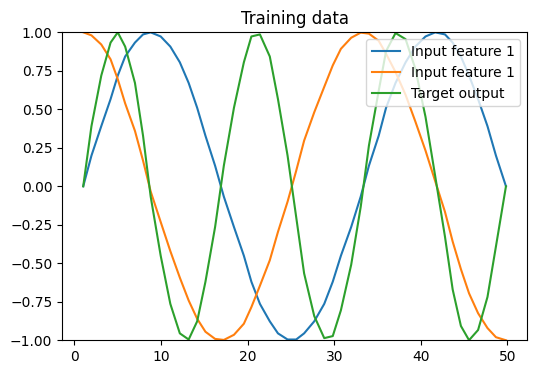

In [ ]:
N = 48 # Length of the time-series
# Input feature is a sine and a cosine wave
data_x = np.stack(
    [np.sin(np.linspace(0, 3 * np.pi, N)), np.cos(np.linspace(0, 3 * np.pi, N))], axis=1
)
data_x = np.expand_dims(data_x, axis=0).astype(np.float32)  # Add batch dimension
data_t = np.random.default_rng().uniform(0.8,1.2, size=(1,N,1))
# Irregularly sampled time (uniform between 0.8 and 1.2 seconds)
# Target output is a sine with double the frequency of the input signal
data_y = np.sin(np.linspace(0, 6 * np.pi, N)).reshape([1, N, 1]).astype(np.float32)
print("data_x.shape: ", str(data_x.shape))
print("data_t.shape: ", str(data_t.shape))
print("data_y.shape: ", str(data_y.shape))

# Let's visualize the training data
plt.figure(figsize=(6, 4))
# To conver the relative time steps into absolute time,
# we have to do a "cumulative summation" (np.cumsum)
plt.plot(np.cumsum(data_t[0,:,0]), data_x[0, :, 0], label="Input feature 1")
plt.plot(np.cumsum(data_t[0,:,0]), data_x[0, :, 1], label="Input feature 1")
plt.plot(np.cumsum(data_t[0,:,0]), data_y[0, :, 0], label="Target output")
plt.ylim((-1, 1))
plt.title("Training data")
plt.legend(loc="upper right")
plt.show()


### A NCP model with irregularly sampled input

In [ ]:
fc_wiring = wirings.AutoNCP(24, 1)  # 24 units, 1 of which is a motor neuron

input_values = keras.Input(shape=(None, 2)) # Sequence length and feature dimension
input_time = keras.Input(shape=(None,1)) # Sequence length dimension

random_dense_layer = keras.layers.Dense(32,activation="tanh") # linear layer
ltc_layer = LTC(fc_wiring, return_sequences=True)

x = random_dense_layer(input_values) # Feed values into linear layer
x = ltc_layer((x,input_time)) # feed values and time as pair into LTC RNN

model = keras.Model(inputs=(input_values,input_time),outputs=x)

model.compile(
    optimizer=keras.optimizers.Adam(0.01), loss='mean_squared_error'
)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None, 2)]    0           []                               
                                                                                                  
 dense_2 (Dense)                (None, None, 32)     96          ['input_7[0][0]']                
                                                                                                  
 input_8 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                                                  
 ltc_2 (LTC)                    (None, None, 1)      5514        ['dense_2[0][0]',                
                                                                  'input_8[0][0]']          

In [ ]:
# Train the model for 400 epochs (= training steps), input date is now a pair (values, elapsed time)
hist = model.fit(x=(data_x, data_t), y=data_y, batch_size=1, epochs=400,verbose=1)

Epoch 1/400
1/1 [==============================] - 0s 117ms/step - loss: 0.0025
Epoch 2/400
1/1 [==============================] - 0s 149ms/step - loss: 0.0024
Epoch 3/400
1/1 [==============================] - 0s 155ms/step - loss: 0.0024
Epoch 4/400
1/1 [==============================] - 0s 173ms/step - loss: 0.0022
Epoch 5/400
1/1 [==============================] - 0s 212ms/step - loss: 0.0021
Epoch 6/400
1/1 [==============================] - 0s 130ms/step - loss: 0.0020
Epoch 7/400
1/1 [==============================] - 0s 138ms/step - loss: 0.0019
Epoch 8/400
1/1 [==============================] - 0s 181ms/step - loss: 0.0018
Epoch 9/400
1/1 [==============================] - 0s 167ms/step - loss: 0.0018
Epoch 10/400
1/1 [==============================] - 0s 169ms/step - loss: 0.0018
Epoch 11/400
1/1 [==============================] - 0s 199ms/step - loss: 0.0018
Epoch 12/400
1/1 [==============================] - 0s 171ms/step - loss: 0.0017
Epoch 13/400
1/1 [===================